# Set Covering

In [124]:
from random import random, seed
from itertools import accumulate
import numpy as np
from tqdm.auto import tqdm
from icecream import ic
from matplotlib import pyplot as plt
import math

In [125]:
UNIVERSE_SIZE = 10000
NUM_SETS = 1000
DENSITY = 0.3
MAX_STEPS = 1000
rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [126]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

*Helper function*

In [127]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

def fitness(solution):
    """Returns the fitness of a solution"""
    return (valid(solution), -cost(solution)) 

# First dumb solutions

In [128]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(6682395.949306458))

In [129]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.True_, np.float64(3320945.6048427536))

# Hill Climbing solution Single-RM

In [130]:
def tweak1(solution):
    """Returns a new solution by flipping a random set"""
    new_solution = solution.copy()
    index= rng.integers(NUM_SETS)
    new_solution[index] = ~new_solution[index]
    return new_solution
    

In [131]:
def starting_point():
    """Returns a valid starting point"""
    solution = rng.random(NUM_SETS) < 1
    return solution

ic| fitness(solution): (np.True_, np.float64(-2412347.3980405107))
ic| history.index(fitness(solution)): 1000


(np.True_, np.float64(2412347.3980405107))

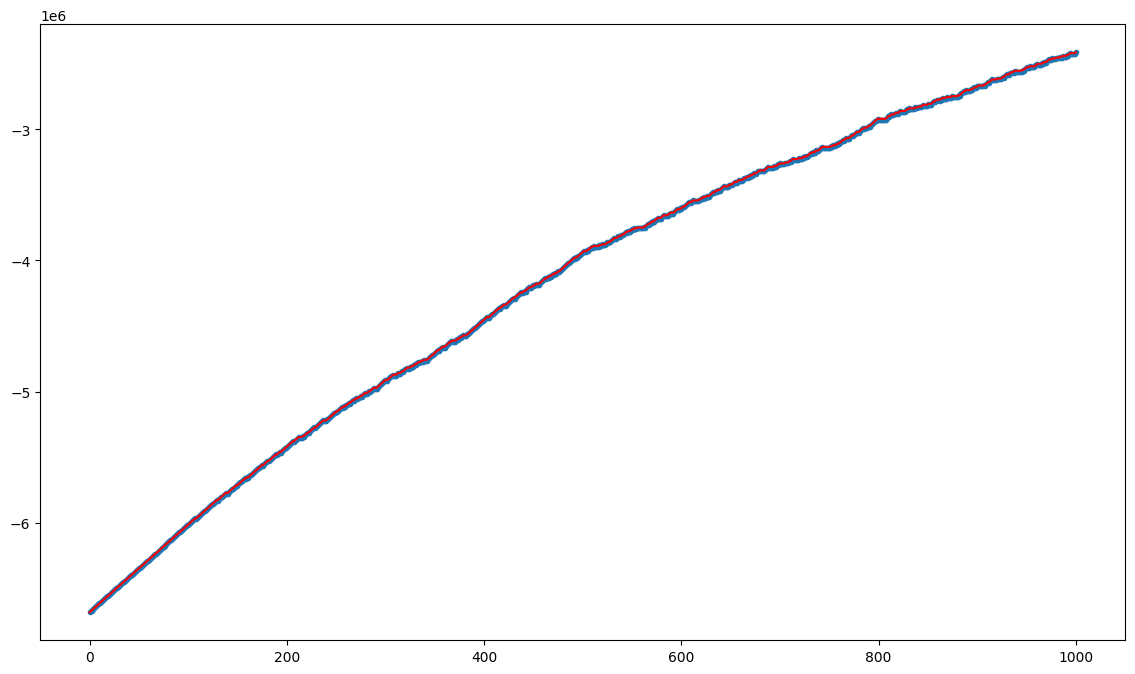

In [133]:
def hill_climb(tweak, sp):
    solution = sp()
    history = [fitness(solution)]
    for _ in range(MAX_STEPS):
        new_solution = tweak(solution)
        history.append(fitness(new_solution))
        if fitness(new_solution) > fitness(solution):
            solution = new_solution
    
    ic(fitness(solution))
    ic(history.index(fitness(solution)))    
    c_values = [c for v, c in history]

    plt.figure(figsize=(14, 8))

    # Grafico dell'accumulazione del massimo di 'c'
    plt.plot(
        range(len(c_values)),
        list(accumulate(c_values, max)),
        color="red",
    )

    # Scatter plot per visualizzare i singoli valori di 'c'
    _ = plt.scatter(range(len(c_values)), c_values, marker=".")
    return solution
solution = hill_climb(tweak1, starting_point)
valid(solution), cost(solution)

# Hill Climbing Multiple-RMHC

In [134]:
def tweak2(solution):
    new_solution = solution.copy()
    index = None
    while index is None or np.random.random() < 0.4:
        index= rng.integers(NUM_SETS)
        new_solution[index] = ~new_solution[index]
    return new_solution

ic| fitness(solution): (np.True_, np.float64(-2165961.186777978))
ic| history.index(fitness(solution)): 995


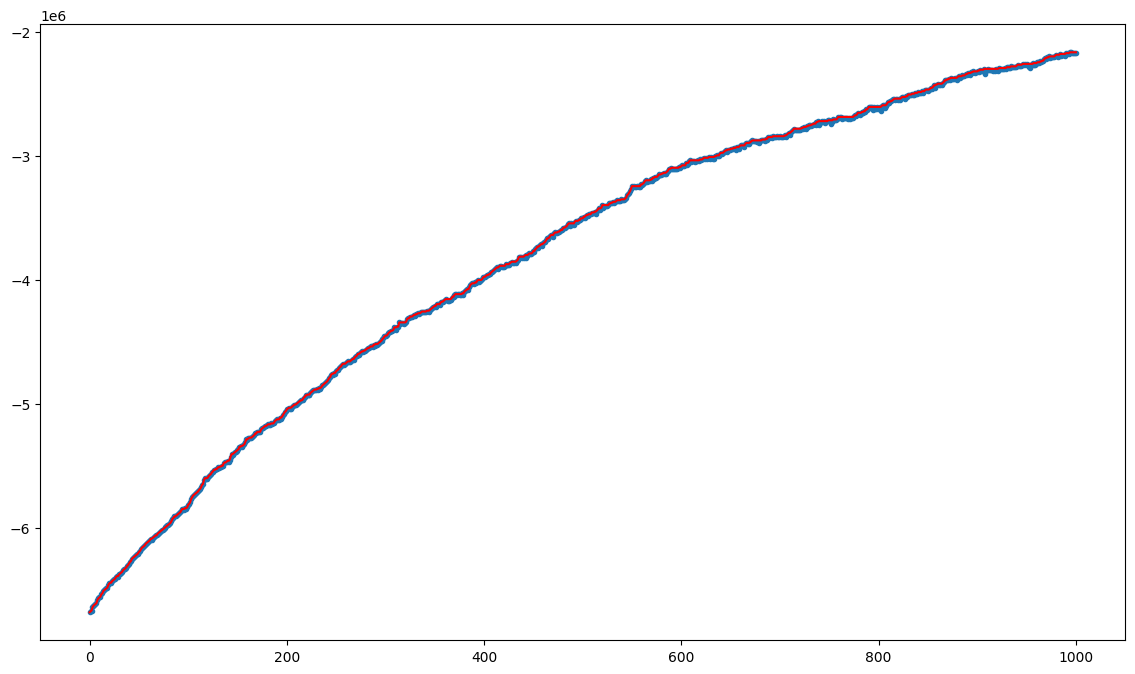

In [135]:

solution = hill_climb(tweak2, starting_point)
None

# Hill Climbing  Multiple-RMHC (2° Version)

In [136]:
def tweak2_improved(solution):
    new_solution = solution.copy()
    
    # Decide casualmente se attivare o disattivare un set
    activate_set = rng.random() < 0.5
    
    # Se decidiamo di attivare un set, cerchiamo un set non attivo
    if activate_set:
        candidates = np.where(new_solution == False)[0]
        if len(candidates) > 0:
            # Seleziona casualmente un set tra quelli non attivi
            index = rng.choice(candidates)
            new_solution[index] = True
    else:
        # Altrimenti, disattiva casualmente un set tra quelli attivi
        candidates = np.where(new_solution == True)[0]
        if len(candidates) > 0:
            index = rng.choice(candidates)
            new_solution[index] = False
    
    # Aggiunge una probabilità aggiuntiva di ulteriori tweak
    while np.random.random() < 0.5:
        index = rng.integers(NUM_SETS)
        new_solution[index] = ~new_solution[index]
    
    return new_solution


ic| fitness(solution): (np.True_, np.float64(-1928497.8887476707))
ic| history.index(fitness(solution)): 1000


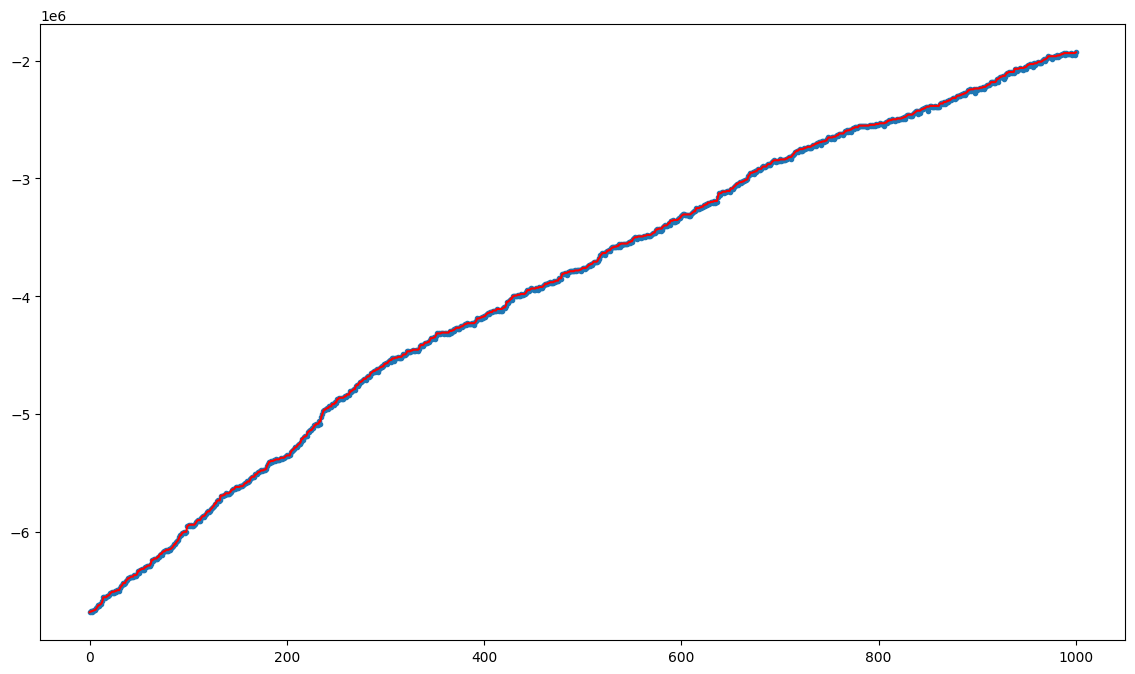

In [137]:
hill_climb(tweak2_improved, starting_point)
None

# Steepest step and restart

  0%|          | 0/3 [00:00<?, ?it/s]

step 1:   0%|          | 0/66 [00:00<?, ?it/s]

step 2:   0%|          | 0/66 [00:00<?, ?it/s]

step 3:   0%|          | 0/66 [00:00<?, ?it/s]

(np.True_, np.float64(5462286.03800391))

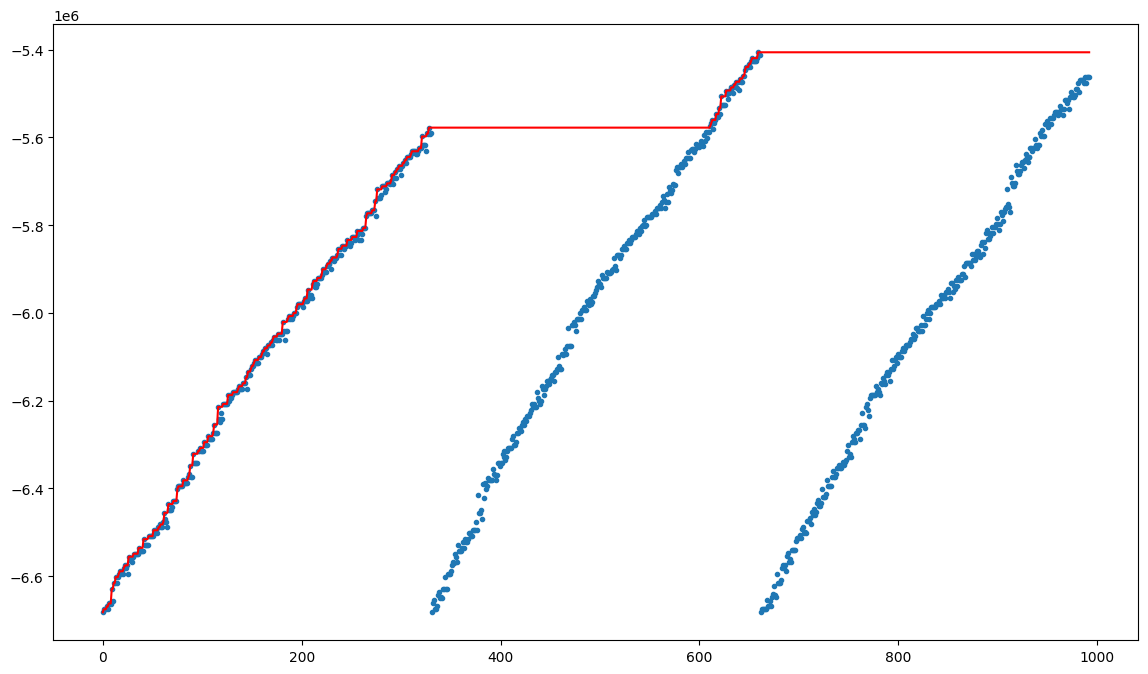

In [138]:
NUM_RESTARTS = 3
STEEPEST_STEP_CANDIDATES = 5
TRUE_MAX_STEPS = MAX_STEPS // STEEPEST_STEP_CANDIDATES
history = list()
for i in tqdm(range(NUM_RESTARTS), position=0):
    solution = starting_point()
    history.append(fitness(solution))
    for _ in tqdm (range(TRUE_MAX_STEPS//NUM_RESTARTS), position=1, desc=f'step {i+1}'):
        candidates = [tweak2(solution) for _ in range(STEEPEST_STEP_CANDIDATES)]
        candidates_fitness = list()

        for candidate in candidates:
            candidates_fitness.append(fitness(candidate))
            history.append(fitness(candidate))
        idx = candidates_fitness.index(max(candidates_fitness))   
        new_solution = candidates[idx]
        new_fitness = candidates_fitness[idx]
        if new_fitness > fitness(solution):
            solution = new_solution
plt.figure(figsize=(14, 8))
c_values = [c for v, c in history]
plt.plot(
    range(len(c_values)),
    list(accumulate(c_values, max)),
    color="red",
)
_ = plt.scatter(range(len(c_values)), c_values, marker=".")
valid(solution), cost(solution)


# Simulated Annealing

ic| fitness(Best): (np.True_, np.float64(-6682395.949306458))
ic| history.index(fitness(Best)): 0


(np.True_, np.float64(6682395.949306458))

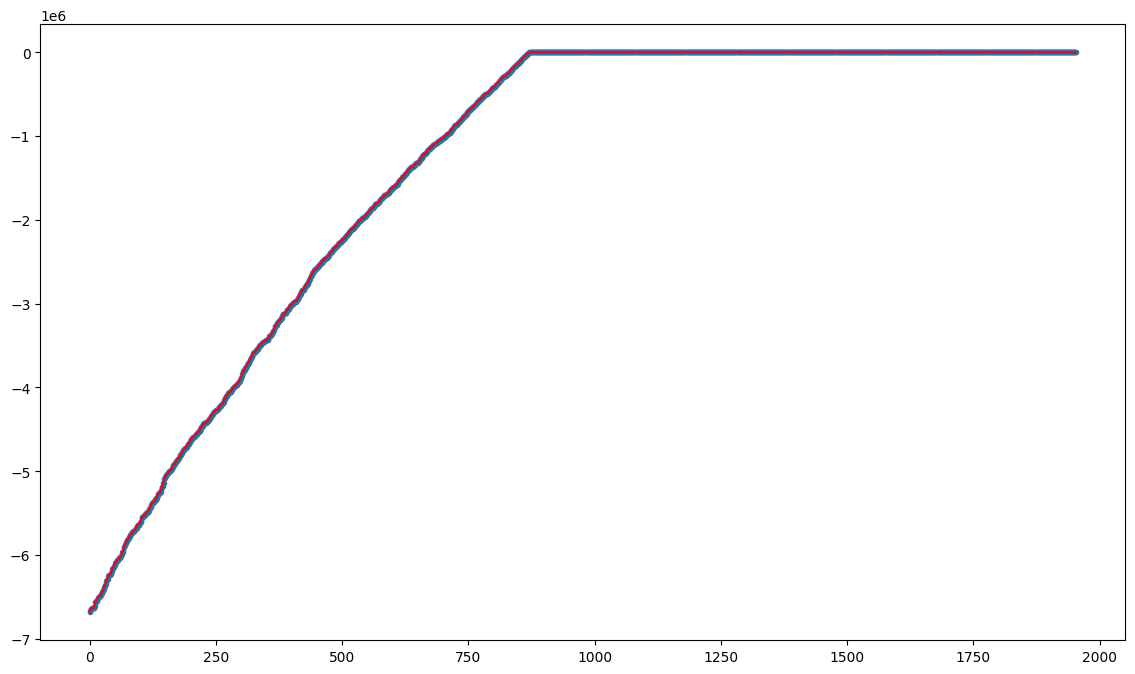

In [151]:
INITIAL_TEMPERATURE = 1000  # Temperatura iniziale
COOLING_RATE = 0.995  # Fattore di raffreddamento

def simulated_annealing(tweak, sp):
    # Punto di partenza iniziale
    S = sp()  # Soluzione iniziale
    Best = S.copy()  # Migliore soluzione trovata
    current_fitness = fitness(S)  # Fitness della soluzione attuale
    current_value, current_cost = current_fitness  # Decomponiamo in V e c

    # Inizializzazione della temperatura
    temperature = INITIAL_TEMPERATURE

    # Storia per tracciare l'andamento della qualità
    history = [(current_value, current_cost)]

    # Loop principale
    while temperature > 1e-10:  # Continua finché la temperatura è alta
        # Crea una nuova soluzione
        R = tweak(S.copy())  # Tweak la soluzione attuale
        new_fitness = fitness(R)  # Fitness della nuova soluzione
        new_value, new_cost = new_fitness  # Decomponiamo in V e c
        
        # Se la nuova soluzione è migliore o accettata casualmente
        if (new_cost > current_cost  ) or rng.random() < math.exp((new_cost - current_cost) / temperature):
            S = R  # Aggiorna la soluzione attuale
            current_value, current_cost = new_value, new_cost  # Aggiorna la qualità
            history.append((current_value, current_cost))  # Memorizza la storia
            
            # Aggiorna Best se la nuova soluzione è migliore
            if new_cost > fitness(Best)[0]:  # Confronta solo il valore
                Best = S.copy()  # Aggiorna la migliore soluzione

        # Riduci la temperatura
        temperature *= COOLING_RATE
    ic(fitness(Best))
    ic(history.index(fitness(Best)))
    # Estrai i valori di V e c per la visualizzazione
   
    plt.figure(figsize=(14, 8))
    c_values = [c for v, c in history]
    plt.plot(
    range(len(c_values)),
    list(accumulate(c_values, max)),
    color="red",
    )
    _ = plt.scatter(range(len(c_values)), c_values, marker=".")
    return Best  # Restituisce la migliore soluzione trovata

# Esegui il Simulated Annealing
solution = simulated_annealing(tweak2_improved, starting_point)
valid(solution), cost(solution)
